# Определение перспективного тарифа для телеком компании

## Описание проекта
Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

#### Описание тарифов

Тариф «Смарт»

- Ежемесячная плата: 550 рублей

- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика

- Стоимость услуг сверх тарифного пакета:
 - минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.)
 - сообщение: 3 рубля
 - 1 Гб интернет-трафика: 200 рублей
 
Тариф «Ультра»

- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
 - минута разговора: 1 рубль
 - сообщение: 1 рубль
 - 1 Гб интернет-трафика: 150 рублей

### Описание данных

#### Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

#### Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

#### Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

#### Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

#### Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Изучение общей информации

In [1]:
#импортируем библиотеки и методы
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
from math import factorial

import warnings 
warnings.filterwarnings("ignore") 

In [2]:
#загружаем датасеты
calls = pd.read_csv('/home/andrey/Datasets/calls.csv')
internet = pd.read_csv('/home/andrey/Datasets/internet.csv')
messages = pd.read_csv('/home/andrey/Datasets/messages.csv')
tariffs = pd.read_csv('/home/andrey/Datasets/tariffs.csv')
users = pd.read_csv('/home/andrey/Datasets/users.csv')

In [3]:
#изучим calls
print(calls.info())
print('__________________')
print(calls['duration'].describe())
print('__________________')
print(calls['duration'].value_counts())
print('__________________')
calls.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None
__________________
count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64
__________________
0.00     39613
4.49       142
5.50       142
6.15       141
6.38       141
         ...  
27.02        1
26.19        1
25.34        1
27.13        1
24.28        1
Name: duration, Length: 2871, dtype: int64
__________________


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


Необходимо изменить тип данных в столбце call_date.
Видно что есть звонки длительностью в 0 минут, необходимо исправить данную ошибку. Количество 'нулевых' звонков составляет почти 20% от общего количества значений.

In [4]:
#изучим internet
print(internet.info())
print('__________________')
print(internet.describe())
print('__________________')
print(internet['mb_used'].value_counts())
print('__________________')
internet.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None
__________________
          Unnamed: 0        mb_used        user_id
count  149396.000000  149396.000000  149396.000000
mean    74697.500000     370.192426    1252.099842
std     43127.054745     278.300951     144.050823
min         0.000000       0.000000    1000.000000
25%     37348.750000     138.187500    1130.000000
50%     74697.500000     348.015000    1251.000000
75%    112046.250000     559.552500    1380.000000
max    149395.000000    1724.830000    1499.000000
__________________
0.00      19598
19

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


В данном df анологичная ситуация с датой и нулевым количеством потраченных мегабайт трафика.

In [5]:
#изучим messages
print(messages.info())
print('__________________')
print(messages.describe())
print('__________________')
messages.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None
__________________
             user_id
count  123036.000000
mean     1256.989410
std       143.523967
min      1000.000000
25%      1134.000000
50%      1271.000000
75%      1381.000000
max      1499.000000
__________________


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


В таблице messages столбец message_date так же необходимо привести к типу данных datetime

In [6]:
#изучим tariffs
print(tariffs.info())
print('__________________')
tariffs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None
__________________


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [7]:
#изучим users
print(users.info())
print('__________________')
print(users.describe())
print('__________________')
users.head(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None
__________________
           user_id        age
count   500.000000  500.00000
mean   1249.500000   46.58800
std     144.481833   16.66763
min    1000.000000   18.00000
25%    1124.750000   32.00000
50%    1249.500000   46.00000
75%    1374.250000   62.00000
max    1499.000000   75.00000
__________________


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


Так же столбец churn_date необходимо привести к типу datetime

Необходимо привести столбцы с датами к формату datetime.

Нулевые значения и значения менее 1 минуты и менее 1 мб необходимо заменить на 1 минуты и 1 мб соответственно. Т.к. оператор тарифицирует это как полную минуты и потраченный мб. Так же данные необходимо "округлить" в большую сторону для соответствия рассчётов тарификации оператора.

Нулевые значения в минутах могли появится из за того, что время в минутах рассчитывается в столбце с точностью до двух знаков после запятой, поэтому разговоры продлившеся примерно менее половины секунды были округлены до значения 0.00
Такая же логика применима к потраченным мб трафика.

## Подготовка данных

In [8]:
#изменим тип данных object на datetime где это необходимо с помощью функции
def todatetime(column):
    column = pd.to_datetime(column, format= '%Y-%m-%d')
    
todatetime(calls['call_date'])
todatetime(internet['session_date'])
todatetime(messages['message_date'])
todatetime(users['churn_date'])

In [9]:
#добавим столбец тариф в df calls, internet, messages

calls = calls.merge(users[['user_id','tariff']], how = 'left', on='user_id')
internet = internet.merge(users[['user_id','tariff']], how = 'left', on='user_id')
messages = messages.merge(users[['user_id','tariff']], how = 'left', on='user_id')


In [10]:
#Проверим предположение, сделаем срез данных с временем разговора менее 0.5 секунды (примерно 0.009 минуты) и не равные 0.
calls.query('duration < 0.009 & duration != 0')

,id,call_date,duration,user_id,tariff


Таких значений нет, поэтому:
- заменим нули и разгоовры менее минуты на 1 минуту, 
- все остальные разговоры округлим в большую сторону для соответствия тарификации оператора
- для этого прибавим ко всем значениям 1 минуту и переведём в int который округялет в меньшую сторону

In [11]:
calls['duration'] = (calls['duration']//1 + 1)

#проделаем тоже самое с трафиком
internet['mb_used'] = (internet['mb_used']//1 + 1)

In [12]:
#Добавим месяц звонка/смс/интернета
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
internet['month'] = pd.DatetimeIndex(internet['session_date']).month

In [13]:
#объявим переменные по пакетам тарифов
ultra_messages_incl = 1000
ultra_minutes_incl = 3000
ultra_internet_incl = 30720

smart_messages_incl = 50
smart_minutes_incl = 500
smart_internet_incl = 15360

smart_fee = 550
ultra_fee = 1950

rf_gb_ultra = 150
rf_gb_smart = 200

rf_message_ultra = 1
rf_message_smart = 3

rf_minute_ultra = 1
rf_minute_smart = 3

## Произведение рассчётов

#### Количество сделанных звонков и израсходованных минут разговора по месяцам.

In [14]:
calls_pivot = calls.pivot_table(index = ('user_id','tariff','month'),
                                values = 'duration',
                                aggfunc = ('sum')).fillna(0).reset_index()

calls_pivot.head()

,user_id,tariff,month,duration
0,1000,ultra,5,164.0
1,1000,ultra,6,187.0
2,1000,ultra,7,346.0
3,1000,ultra,8,419.0
4,1000,ultra,9,479.0


#### Количество отправленных сообщений по месяцам.

In [15]:
messages_pivot = messages.pivot_table(index = ('user_id','tariff','month'),
                                values = 'id',
                                aggfunc = 'count').fillna(0).reset_index()

messages_pivot.head()

,user_id,tariff,month,id
0,1000,ultra,5,22
1,1000,ultra,6,60
2,1000,ultra,7,75
3,1000,ultra,8,81
4,1000,ultra,9,57


#### Объем израсходованного интернет-трафика по месяцам.

In [16]:
internet_pivot = internet.pivot_table(index = ('user_id','tariff', 'month'),
                                values = 'mb_used',
                                aggfunc = 'sum').fillna(0).reset_index()

internet_pivot.head()

,user_id,tariff,month,mb_used
0,1000,ultra,5,2257.0
1,1000,ultra,6,23262.0
2,1000,ultra,7,14017.0
3,1000,ultra,8,14072.0
4,1000,ultra,9,14583.0


##### Помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [17]:
#объединим всё траты вместе и добавим город 
all_pivot = internet_pivot.merge(calls_pivot[['user_id','duration','month']], how = 'left', on=('user_id','month')).merge(
    messages_pivot[['user_id','id','month']], how = 'left', on=('user_id','month')).merge(
    users[['city','user_id']], how= 'left', on=('user_id'))
all_pivot.rename(columns=lambda x: x.replace('id', 'messages_send'), inplace=True)  
all_pivot.rename(columns=lambda x: x.replace('user_messages_send', 'user_id'), inplace=True)
    
all_pivot

,user_id,tariff,month,mb_used,duration,messages_send,city
0,1000,ultra,5,2257.0,164.0,22.0,Краснодар
1,1000,ultra,6,23262.0,187.0,60.0,Краснодар
2,1000,ultra,7,14017.0,346.0,75.0,Краснодар
3,1000,ultra,8,14072.0,419.0,81.0,Краснодар
4,1000,ultra,9,14583.0,479.0,57.0,Краснодар
...,...,...,...,...,...,...,...
3198,1498,smart,10,20614.0,259.0,42.0,Владикавказ
3199,1499,smart,9,1849.0,71.0,11.0,Пермь
3200,1499,smart,10,17824.0,474.0,48.0,Пермь
3201,1499,smart,11,17994.0,624.0,59.0,Пермь


In [18]:
#Рассчитаем помесячный доход по тарифу ультра
all_ultra = all_pivot.query('tariff == "ultra"').fillna(0)

#сделаем функцию для рассчёта свехлимитов по тарифу
def profit_ultra_i(mci):
    if mci < ultra_internet_incl:
        return 0
    else:
        return ((mci - ultra_internet_incl)//1024 + 1)*rf_gb_ultra

#добавим столбец с тратами больше лимита
all_ultra['internet_profit'] = all_ultra['mb_used'].apply(profit_ultra_i)

def profit_ultra_m(mci):
    if mci < ultra_messages_incl:
        return 0
    else:
        return (mci - ultra_messages_incl)*rf_message_ultra
    
all_ultra['messages_profit'] = all_ultra['messages_send'].apply(profit_ultra_m)

def profit_ultra_c(mci):
    if mci < ultra_minutes_incl:
        return 0
    else:
        return (mci - ultra_minutes_incl)*rf_minute_ultra 
    
all_ultra['calls_profit'] = all_ultra['duration'].apply(profit_ultra_c)

#соединим все расходы клиента
all_ultra['total_profit'] = all_ultra['calls_profit'] + all_ultra['messages_profit'] + all_ultra['internet_profit'] + ultra_fee

all_ultra

,user_id,tariff,month,mb_used,duration,messages_send,city,internet_profit,messages_profit,calls_profit,total_profit
0,1000,ultra,5,2257.0,164.0,22.0,Краснодар,0.0,0,0,1950.0
1,1000,ultra,6,23262.0,187.0,60.0,Краснодар,0.0,0,0,1950.0
2,1000,ultra,7,14017.0,346.0,75.0,Краснодар,0.0,0,0,1950.0
3,1000,ultra,8,14072.0,419.0,81.0,Краснодар,0.0,0,0,1950.0
4,1000,ultra,9,14583.0,479.0,57.0,Краснодар,0.0,0,0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...
3175,1495,ultra,8,2616.0,96.0,13.0,Иркутск,0.0,0,0,1950.0
3176,1495,ultra,9,33109.0,833.0,82.0,Иркутск,450.0,0,0,2400.0
3177,1495,ultra,10,29399.0,1057.0,82.0,Иркутск,0.0,0,0,1950.0
3178,1495,ultra,11,38974.0,972.0,79.0,Иркутск,1350.0,0,0,3300.0


In [19]:
#Рассчитаем помесячный доход по тарифу смарт

all_smart = all_pivot.query('tariff == "smart"').fillna(0)

def profit_smart_i(mci):
    if mci < smart_internet_incl:
        return 0
    else:
        return ((mci - smart_internet_incl)//1024 + 1)*rf_gb_smart
    
all_smart['internet_profit'] = all_smart['mb_used'].apply(profit_smart_i)

def profit_smart_m(mci):
    if mci < smart_messages_incl:
        return 0
    else:
        return (mci - smart_messages_incl)*rf_message_smart
    
all_smart['messages_profit'] = all_smart['messages_send'].apply(profit_smart_m)

def profit_smart_c(mci):
    if mci < smart_minutes_incl:
        return 0
    else:
        return (mci - smart_minutes_incl)*rf_minute_smart

all_smart['calls_profit'] = all_smart['duration'].apply(profit_smart_c)

#соединим все расходы клиента

all_smart['total_profit'] = all_smart['calls_profit'] + all_smart['messages_profit'] + all_smart['internet_profit'] + smart_fee
all_smart

,user_id,tariff,month,mb_used,duration,messages_send,city,internet_profit,messages_profit,calls_profit,total_profit
8,1001,smart,11,18460.0,444.0,0.0,Москва,800.0,0.0,0.0,1350.0
9,1001,smart,12,14059.0,430.0,0.0,Москва,0.0,0.0,0.0,550.0
10,1002,smart,6,10878.0,118.0,4.0,Стерлитамак,0.0,0.0,0.0,550.0
11,1002,smart,7,17615.0,219.0,11.0,Стерлитамак,600.0,0.0,0.0,1150.0
12,1002,smart,8,20358.0,296.0,13.0,Стерлитамак,1000.0,0.0,0.0,1550.0
...,...,...,...,...,...,...,...,...,...,...,...
3198,1498,smart,10,20614.0,259.0,42.0,Владикавказ,1200.0,0.0,0.0,1750.0
3199,1499,smart,9,1849.0,71.0,11.0,Пермь,0.0,0.0,0.0,550.0
3200,1499,smart,10,17824.0,474.0,48.0,Пермь,600.0,0.0,0.0,1150.0
3201,1499,smart,11,17994.0,624.0,59.0,Пермь,600.0,27.0,372.0,1549.0


In [20]:
#уберём из резульатов месяц подключения и месяц отключения пакета 
all_smart = all_smart.query('duration > 15')
all_ultra = all_ultra.query('duration > 15')

## Анализ данных

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

In [21]:
#проанализируем время разговора.

print('Тариф Ультра')
print(all_ultra['duration'].describe())
print('----------------------')
print('')
print('Тариф смарт')
all_smart['duration'].describe()

Тариф Ультра
count     929.000000
mean      571.397201
std       310.228386
min        16.000000
25%       333.000000
50%       551.000000
75%       780.000000
max      1728.000000
Name: duration, dtype: float64
----------------------

Тариф смарт


count    2206.000000
mean      434.307797
std       191.228057
min        16.000000
25%       297.000000
50%       438.000000
75%       562.000000
max      1473.000000
Name: duration, dtype: float64

In [22]:
calls_ultra_mean = 571
calls_smart_mean = 434
calls_ultra_std = 310.228386
calls_smart_std = 191.228057
print('Среднее значение потраченных минут в тарифе ультра составляет:', calls_ultra_mean)
print('Среднее значение потраченных минут в тарифе смарт составляет:', calls_smart_mean)
print()
print('Стандартное отклонение в потраченных минутах в тарифе ультра:', calls_ultra_std)
print('Стандартное отклонение в потраченных минутах в тарифе смарт:', calls_smart_std)
print()
print('Дисперсия в потраченных минутах в тарифе ультра', calls_ultra_std**2)
print('Дисперсия в потраченных минутах в тарифе смарт', calls_smart_std**2)

Среднее значение потраченных минут в тарифе ультра составляет: 571
Среднее значение потраченных минут в тарифе смарт составляет: 434

Стандартное отклонение в потраченных минутах в тарифе ультра: 310.228386
Стандартное отклонение в потраченных минутах в тарифе смарт: 191.228057

Дисперсия в потраченных минутах в тарифе ультра 96241.65148016499
Дисперсия в потраченных минутах в тарифе смарт 36568.169783995254


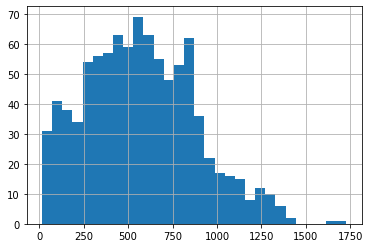

In [23]:
#Построим гистограммы
all_ultra['duration'].hist(bins=30)

Исходя из гистограммы потраченного времени на разговоры в тарифе "Ультра", можно сделать вывод, что клиенты в среднем тратя на разговоры по 571 минуте в месяц, а клиентов тратящих более 1500 минут из 3000 выделенных практичесик нет.

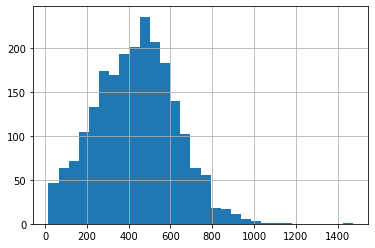

In [24]:
all_smart['duration'].hist(bins=30)

Время потраченное на разговоры у клиентов в тарифе "Смарт" в среднем меньше чем у клиентов которые используют тариф "Ультра", при этом практически 40% клиентов выходят за предосталвенный лимит в 500 минут в месяц.

In [25]:
#проанализируем отправленные клиентами смс сообщения.

print('Тариф Ультра')
print(all_ultra['messages_send'].describe())
print('----------------------')
print('')
print('Тариф смарт')
all_smart['messages_send'].describe()

Тариф Ультра
count    929.000000
mean      48.916039
std       46.692449
min        0.000000
25%        5.000000
50%       40.000000
75%       79.000000
max      224.000000
Name: messages_send, dtype: float64
----------------------

Тариф смарт


count    2206.000000
mean       33.495920
std        28.276986
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: messages_send, dtype: float64

In [26]:
messages_ultra_mean = 48
messages_smart_mean = 33
messages_ultra_std = 46.692449
messages_smart_std = 28.276986
print('Среднее значение потраченных минут в тарифе ультра составляет:', messages_ultra_mean)
print('Среднее значение потраченных минут в тарифе смарт составляет:', messages_smart_mean)
print()
print('Стандартное отклонение в потраченных минутах в тарифе ультра:', messages_ultra_std)
print('Стандартное отклонение в потраченных минутах в тарифе смарт:', messages_smart_std)
print()
print('Дисперсия в потраченных минутах в тарифе ультра', messages_ultra_std**2)
print('Дисперсия в потраченных минутах в тарифе смарт', messages_smart_std**2)

Среднее значение потраченных минут в тарифе ультра составляет: 48
Среднее значение потраченных минут в тарифе смарт составляет: 33

Стандартное отклонение в потраченных минутах в тарифе ультра: 46.692449
Стандартное отклонение в потраченных минутах в тарифе смарт: 28.276986

Дисперсия в потраченных минутах в тарифе ультра 2180.1847936176014
Дисперсия в потраченных минутах в тарифе смарт 799.587937244196


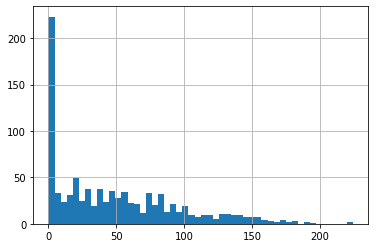

In [27]:
#Построим гистограммы
all_ultra['messages_send'].hist(bins=50)

Большое количество клиентов не отправляет СМС сообщения, либо отправляет крайне мало смс в среднем, однако пользователи тарифа "ультра" в среднем отправляют сообщений больше чем пользователи тарифа "смарт".

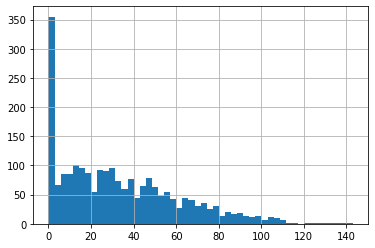

In [28]:
all_smart['messages_send'].hist(bins=50)

Гистограмма распределения количества отправленных смс сообщений пользователями тарифа "смарт", распределена так же как и у пользователей тарифа "ультра", но в среднем они отправляют меньше сообщений в месяц.

In [29]:
#проанализируем количество потраченных мб интернет трафика

print('Тариф Ультра')
print(all_ultra['mb_used'].describe())
print('----------------------')
print('')
print('Тариф смарт')
all_smart['mb_used'].describe()

Тариф Ультра
count      929.000000
mean     19752.625404
std       9948.908230
min          1.000000
25%      12064.000000
50%      19447.000000
75%      26954.000000
max      49793.000000
Name: mb_used, dtype: float64
----------------------

Тариф смарт


count     2206.000000
mean     16289.607434
std       5814.658744
min          1.000000
25%      12753.250000
50%      16551.500000
75%      20080.500000
max      38628.000000
Name: mb_used, dtype: float64

In [30]:
internet_ultra_mean = 19753
internet_smart_mean = 16290
internet_ultra_std = 9948.908230
internet_smart_std = 5814.658744
print('Среднее значение потраченных минут в тарифе ультра составляет:', internet_ultra_mean)
print('Среднее значение потраченных минут в тарифе смарт составляет:', internet_smart_mean)
print()
print('Стандартное отклонение в потраченных минутах в тарифе ультра:', internet_ultra_std)
print('Стандартное отклонение в потраченных минутах в тарифе смарт:', internet_smart_std)
print()
print('Дисперсия в потраченных минутах в тарифе ультра', internet_ultra_std**2)
print('Дисперсия в потраченных минутах в тарифе смарт', internet_smart_std**2)

Среднее значение потраченных минут в тарифе ультра составляет: 19753
Среднее значение потраченных минут в тарифе смарт составляет: 16290

Стандартное отклонение в потраченных минутах в тарифе ультра: 9948.90823
Стандартное отклонение в потраченных минутах в тарифе смарт: 5814.658744

Дисперсия в потраченных минутах в тарифе ультра 98980774.96896172
Дисперсия в потраченных минутах в тарифе смарт 33810256.30917566


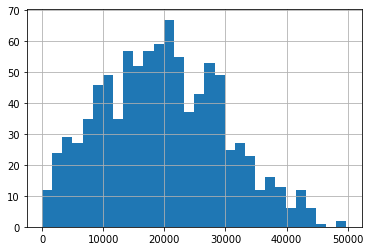

In [31]:
#Построим гистограммы
all_ultra['mb_used'].hist(bins=30)

У клиентов тарифа ульра гистограмма потраченного трафика распределена слегка скошена в право. Клиенты в данном тарифе реже уходят за лимит предоплаченного трафика.

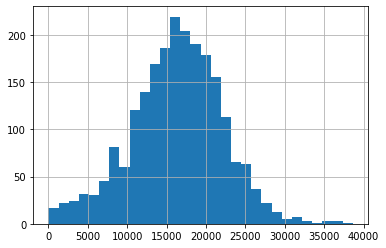

In [32]:
all_smart['mb_used'].hist(bins=30)

Гистограмма по тарифу смарт распределена нормально. Однако, клиенты подключившие данный тариф более чем в 55% случаев уходят за предоставленный лимит трафика.

Проанализировав поведение клиентов, можно сделать вывод, что клиенты в тарифе "ультра" в достаточно редко уходят за лимиты предоставленные в тарфие(только по тратам интернет трафика). 
Клиенты тарифа "смарт", напротив, чаще выходят за лимит предоставленный тарифом(за звонки примерно 40% пользователей, за интернет примерно 55%)

## Проверьте гипотезы:

#### средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

- проверим гипотезу о равенстве средних двух генеральных совокупностей
- нулевая гипотеза: средняя выручка не отличается
- альтернативная гипотеза: средняя выручка различается

In [33]:
#критический уровень статистической значимости
alpha = .05

result = st.ttest_ind(
    all_smart['total_profit'], 
    all_ultra['total_profit'])

print('p-значение:', result.pvalue)

if (result.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.0075660231274727e-140
Отвергаем нулевую гипотезу


Исходя из полученных данных, из выборки клиентов, можно предположить, что средняя выручка от пользователей, в зависимости от тарифа различается.

####  Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

- проверим гипотезу о равенстве средних двух генеральных совокупностей
- нулевая гипотеза: средняя выручка не отличается
- альтернативная гипотеза: средняя выручка различается

In [34]:
moscow_smart = all_smart.query('city == "Москва"')
moscow_ultra = all_ultra.query('city == "Москва"')

other_smart = all_smart.query('city != "Москва"')
other_ultra = all_ultra.query('city != "Москва"')


In [35]:
# для тарифа смарт

result = st.ttest_ind(
    moscow_smart['total_profit'], 
    other_smart['total_profit'])

print('p-значение:', result.pvalue)

if (result.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.1916483028528539
Не получилось отвергнуть нулевую гипотезу


In [36]:
# для тарифа ультра
result = st.ttest_ind(
    moscow_ultra['total_profit'], 
    other_ultra['total_profit'])

print('p-значение:', result.pvalue)

if (result.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.9819911217540285
Не получилось отвергнуть нулевую гипотезу


Вне зависимости от тарифного плана, можно предположить, что средняя выручка на одного клиента не различается у пользователей из Москвы и пользователей из других городов.

## Общий вывод

Проанализировав и изучив выборку клиентов можно сделать следующие выводы:
Клиенты которые используют тариф "Смарт" практически в половине случаев несут дополнительные расходы, на оплату минут или гб интернета. 
Клиенты в тарифе "Ультра", напротив достаточно редко тратят больше чем оплата за тарифный план. (Только за дополнительные гб интернета)

Средняя выручка от разных тарифов предположительно различается. При этом, не имеет значения в каком городе подключен тариф, клиенты, приносят прибыль, примерно одинакого, независимо от того находятся они в Москве или в каком то другом городе.